In [20]:
!pip install rdkit-pypi

In [21]:
!pip install --upgrade rdkit

In [22]:
!apt-get update -qq && apt-get install -y libboost-dev libboost-filesystem-dev libboost-system-dev
!pip install pyboost

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libboost-dev is already the newest version (1.74.0.3ubuntu7).
libboost-filesystem-dev is already the newest version (1.74.0.3ubuntu7).
libboost-system-dev is already the newest version (1.74.0.3ubuntu7).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.
  Using cached pyboost-0.1.dev18.tar.gz (19 kB)
  Preparing metadata (setup.py) ... done
  Using cached zetup-0.2.64.tar.gz (61 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Enco

In [4]:
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.3 MB/s eta 0:00:00


In [5]:
# загружаем файлы для теста
from google.colab import files
uploaded = files.upload()

Saving Zn.sdf to Zn.sdf
Saving Co.sdf to Co.sdf
Saving Y.sdf to Y.sdf
Saving Ce.sdf to Ce.sdf
Saving Cf.sdf to Cf.sdf
Saving Cm.sdf to Cm.sdf
Saving Cu.sdf to Cu.sdf
Saving Dy.sdf to Dy.sdf
Saving Er.sdf to Er.sdf
Saving Eu.sdf to Eu.sdf
Saving Fe.sdf to Fe.sdf
Saving Gd.sdf to Gd.sdf
Saving Hg.sdf to Hg.sdf
Saving Ho.sdf to Ho.sdf
Saving La.sdf to La.sdf
Saving Lu.sdf to Lu.sdf
Saving Mg.sdf to Mg.sdf
Saving Mn.sdf to Mn.sdf
Saving Nd.sdf to Nd.sdf
Saving Ni.sdf to Ni.sdf
Saving Pb.sdf to Pb.sdf
Saving Pr.sdf to Pr.sdf
Saving Sm.sdf to Sm.sdf
Saving Tb.sdf to Tb.sdf
Saving Th.sdf to Th.sdf
Saving Tm.sdf to Tm.sdf
Saving U.sdf to U.sdf
Saving Yb.sdf to Yb.sdf
Saving Ca.sdf to Ca.sdf
Saving Cd.sdf to Cd.sdf
Saving Ac.sdf to Ac.sdf
Saving Ag.sdf to Ag.sdf
Saving Al.sdf to Al.sdf
Saving Am.sdf to Am.sdf
Saving Bi.sdf to Bi.sdf
Saving Bk.sdf to Bk.sdf


In [23]:
import numpy as np
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
from rdkit import Chem
from google.colab import drive

In [24]:
name_list=['Ac', 'Ag','Al','Am','Bi','Bk','Ca','Cd','Ce','Cf','Cm','Cu','Dy','Er',
           'Eu','Fe','Gd','Hg','Ho','La','Lu','Mg','Mn','Nd','Ni','Pb','Pr','Sm',
           'Tb','Th','Tm','U','Yb','Y','Co','Zn']
file_list=list(map(lambda x: f'{x}.sdf',name_list))
#делаем доступ к гугл диску, чтобы туда загружать данные
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [16]:
# создаем класс молекулы

class Molecule:
    def __init__(self,mol):
        self.mol=mol
        atom_index=[]
        atom_nums=[]
        for atom in mol.GetAtoms():
            atom_index.append(atom.GetIdx())
            atom_nums.append(atom.GetAtomicNum())
        self.atom_index=np.array(atom_index)
        self.atom_nums=np.array(atom_nums)

        # смотрим, есть ли симметрия относительно поворота на 180
    def symmetry(self):
        self.to_centr()
        positions = self.mol.GetConformer().GetPositions()
        pos=np.array(list(map(lambda x: [x[0],x[1]],positions)))
        rev_mat=np.array([[-1,0],
                          [0,-1]])
        pos_rotate=pos @ rev_mat
        atom_nums = self.atom_nums.reshape(1,-1).T
        atom_positions_true=np.hstack((pos, atom_nums))
        # print(atom_positions_true)
        atom_positions_rotate=np.hstack((pos_rotate, atom_nums))
        # print(atom_positions_rotate)
        return self.equal_after_rotate(atom_positions_true, atom_positions_rotate)
        # разбиваем молекулы на группы по атомам

    def mol_groups(self):
        atom_group_set=set([atom.GetSymbol() for atom in self.mol.GetAtoms()])
        atom_group_list=[]
        atom_list=self.mol.GetAtoms()
        for atom_name in atom_group_set:
            new_mol=Chem.RWMol(self.mol)
            new_mol.BeginBatchEdit()
            index_list=[]
            for atom in atom_list:
                if atom.GetSymbol()==atom_name:
                    # сохраняем старые индексы, так как они теряются
                    index_list.append(atom.GetIdx())
                else:
                     new_mol.RemoveAtom(atom.GetIdx())
            new_mol.CommitBatchEdit()
            for i,atom in enumerate(new_mol.GetAtoms()):
                atom.SetProp('NewIndex', str(index_list[i]))
            final_mol = Molecule(new_mol.GetMol())
            atom_group_list.append(final_mol)
        return atom_group_list

    def get_centr(self):
        positions = self.mol.GetConformer().GetPositions()
        pos=list(map(lambda x: (x[0],x[1]),positions))
        axis_x=[elem[0] for elem in pos]
        axis_y=[elem[1] for elem in pos]
        x0=np.mean(axis_x)
        y0=np.mean(axis_y)
        return x0,y0,self.symmetry()

    def to_centr(self):
        positions = self.mol.GetConformer().GetPositions()
        pos=list(map(lambda x: (x[0],x[1]),positions))
        axis_x=np.array([[elem[0]] for elem in pos])
        axis_y=np.array([[elem[1]] for elem in pos])
        x0=np.mean(axis_x)
        y0=np.mean(axis_y)
        conf=self.mol.GetConformer()
        old_position=conf.GetPositions()
        new_position=-np.array([x0,y0,0.])+old_position
        for i in range(self.mol.GetNumAtoms()):
            conf.SetAtomPosition(i, new_position[i])
    @staticmethod
    def equal_after_rotate(list1,list2,eps=0.005):
            arr1=np.array(list1)
            arr2=np.array(list2)
            for elem in arr1:
                if not np.any(np.all(np.isclose(arr2, elem,rtol=eps,atol=eps), axis=1)):
                    return False
            return True
    # смотрим на сииметри относительно оси, проходящей через плоскость молекулы
    def symmetry_hor(self):
        def rotate_symmetrty(x0,y0,alpha,beta,tau,molecule=self):
            positions = molecule.mol.GetConformer().GetPositions()
            pos=np.array(list(map(lambda x: [x[0],x[1]],positions)))
            dot_prod=tau @ np.array([1,0])
            angle=np.arccos(dot_prod/np.linalg.norm(tau))
            rotate_matrix=np.array([[np.cos(angle),-np.sin(angle)],
                                    [np.sin(angle),np.cos(angle)]])
            x_0=(tau @ rotate_matrix)[0]
            if abs(x_0-np.linalg.norm(tau))>0.0005:
                rotate_matrix=np.array([[np.cos(angle),np.sin(angle)],
                                    [-np.sin(angle),np.cos(angle)]])
            rotate_pos=np.dot(pos, rotate_matrix)
            revered_pos=np.dot(rotate_pos, np.array([[1,0],[0,-1]]))
            atom_nums = []
            for atom in molecule.mol.GetAtoms():
                atom_nums.append([atom.GetAtomicNum()])
            atom_nums=np.array(atom_nums)
            rotate_pos=np.hstack((rotate_pos, atom_nums))
            revered_pos=np.hstack((revered_pos, atom_nums))
            eps=0.05
            old_pos=[]
            new_pos=[]
            for i in range(rotate_pos.shape[0]):
                x=rotate_pos[i,0]
                y=rotate_pos[i,1]
                if abs((y-y0)*alpha-beta*(x-x0))>eps:
                    old_pos.append(rotate_pos[i])
                x=revered_pos[i,0]
                y=revered_pos[i,1]
                if abs((y-y0)*alpha-beta*(x-x0))>eps:
                    new_pos.append(revered_pos[i])
            return  self.equal_after_rotate(old_pos,new_pos,eps=0.05)
        self.to_centr()
        group_list=self.mol_groups()
        if len(group_list)==1:
            return True
        else:
            x0,y0,_=group_list[0].get_centr()
            centr_list=[(x0,y0)]
            flag=0
            eps=0.0001
            for i,molecule in enumerate(group_list[1:]):
                x0,y0,_=molecule.get_centr()
                x1,y1=centr_list[-1]
                if (x0-x1)**2+(y0-y1)**2>eps:
                    flag=1
                    centr_list.append((x0,y0))
            if flag==0:
                return True
            else:
                x0,y0=centr_list[0]
                x1,y1=centr_list[1]
                alpha=x1-x0
                beta=y1-y0
                tau=np.array([x1-x0,y1-y0])

                for centr in centr_list[2:]:
                    x,y=centr
                    if abs((y-y0)*alpha-beta*(x-x0))> eps:
                        return False
                return rotate_symmetrty(x0,y0,alpha,beta,tau,molecule=self)

    # классификация по группам Cn
    def classification(self):
        def is_line():
            positions = self.mol.GetConformer().GetPositions()
            pos=np.array(list(map(lambda x: [x[0],x[1]],positions)))
            if np.linalg.matrix_rank(pos, tol=1e-4)==1:
                return True
            return False
        def z_symmetry(angle=0):
            rotate_matrix=np.array([[np.cos(angle),-np.sin(angle)],
                                    [np.sin(angle),np.cos(angle)]])
            positions = self.mol.GetConformer().GetPositions()
            pos=np.array(list(map(lambda x: [x[0],x[1]],positions)))
            atom_arr=self.atom_nums.reshape(1,-1).T
            pos_rotate=pos @ rotate_matrix
            pos= np.hstack((pos, atom_arr))
            rotate_pos= np.hstack((pos_rotate, atom_arr))
            return self.equal_after_rotate(pos,rotate_pos,eps=0.05)
        n=1
        if self.mol.GetNumAtoms()==1:
            return 'inf'
        self.to_centr()
        if self.symmetry_hor():
            if is_line():
                return 'inf'
            n=2
        m=self.mol.GetNumAtoms()
        for k in range(3,m+1):
            if z_symmetry(2*np.pi/k):
                n=k
        return n

inf


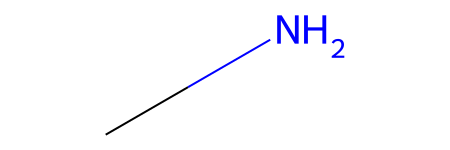

In [25]:
my_molekule=Molecule(Chem.SDMolSupplier('Ag.sdf')[39])
print(my_molekule.classification())
my_molekule.mol

In [26]:
# загрузка картинок для визуальной оценки классификации
#  НЕ ОБЯЗАТЕЛЬНО ЗАПУСКАТЬ
for elem in file_list:
  supplier = Chem.SDMolSupplier(elem)
  num=0
  for mol in supplier:
      num+=1
      try:
          my_mol=Molecule(mol)
          Draw.MolToFile(mol, f'/content/gdrive/My Drive/png_data/classification/молекула_из_{elem}_№{num},группа:С{my_mol.classification()}.png')
      except:
          print(f'молекула_из_{elem}_№{num} имеет проблему в файле')

[19:37:07] Warning: ambiguous stereochemistry - zero final chiral volume - at atom 8 ignored
[19:37:07] Warning: ambiguous stereochemistry - zero final chiral volume - at atom 9 ignored
[19:38:45] ERROR: Counts line too short: '' on line1053
[19:38:45] ERROR: moving to the beginning of the next molecule


молекула_из_U.sdf_№37 имеет проблему в файле
